**Udemy 14. VIP Facial Recognition**

video 4: Loading in the data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from datetime import datetime
from glob import glob
from collections import Counter

In [2]:
# Useful image utility
try:
  %tensorflow_version 2.x # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)
from keras.preprocessing import image

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.8.0


In [3]:
# Data is from: http://vision.ucsd.edu/content/yale-face-database
!wget -nc http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip

--2022-03-15 06:55:45--  http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip
Resolving vision.ucsd.edu (vision.ucsd.edu)... 132.239.95.98
Connecting to vision.ucsd.edu (vision.ucsd.edu)|132.239.95.98|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6206308 (5.9M) [application/zip]
Saving to: ‘yalefaces.zip’

yalefaces.zip       100%[===================>]   5.92M   762KB/s    in 7.8s    

2022-03-15 06:55:53 (775 KB/s) - ‘yalefaces.zip’ saved [6206308/6206308]



In [4]:
!unzip -n yalefaces.zip

Archive:  yalefaces.zip
   creating: yalefaces/
  inflating: yalefaces/Readme.txt    
   creating: __MACOSX/
   creating: __MACOSX/yalefaces/
  inflating: __MACOSX/yalefaces/._Readme.txt  
  inflating: yalefaces/subject01.gif  
  inflating: yalefaces/subject01.glasses  
  inflating: yalefaces/subject01.glasses.gif  
  inflating: yalefaces/subject01.happy  
  inflating: yalefaces/subject01.leftlight  
  inflating: yalefaces/subject01.noglasses  
  inflating: yalefaces/subject01.normal  
  inflating: yalefaces/subject01.rightlight  
  inflating: yalefaces/subject01.sad  
  inflating: yalefaces/subject01.sleepy  
  inflating: yalefaces/subject01.surprised  
  inflating: yalefaces/subject01.wink  
  inflating: yalefaces/subject02.centerlight  
  inflating: yalefaces/subject02.glasses  
  inflating: yalefaces/subject02.happy  
  inflating: yalefaces/subject02.leftlight  
  inflating: yalefaces/subject02.noglasses  
  inflating: yalefaces/subject02.normal  
  inflating: yalefaces/subject02.r

In [5]:
# Get the filepath of all images using the glob function
files = glob('yalefaces/subject*')
files

['yalefaces/subject13.happy',
 'yalefaces/subject15.rightlight',
 'yalefaces/subject12.noglasses',
 'yalefaces/subject15.sleepy',
 'yalefaces/subject12.wink',
 'yalefaces/subject08.wink',
 'yalefaces/subject05.rightlight',
 'yalefaces/subject08.glasses',
 'yalefaces/subject11.sleepy',
 'yalefaces/subject03.sleepy',
 'yalefaces/subject06.centerlight',
 'yalefaces/subject08.centerlight',
 'yalefaces/subject05.sad',
 'yalefaces/subject15.wink',
 'yalefaces/subject15.leftlight',
 'yalefaces/subject09.happy',
 'yalefaces/subject11.sad',
 'yalefaces/subject14.leftlight',
 'yalefaces/subject02.leftlight',
 'yalefaces/subject13.rightlight',
 'yalefaces/subject06.sad',
 'yalefaces/subject13.noglasses',
 'yalefaces/subject09.glasses',
 'yalefaces/subject10.centerlight',
 'yalefaces/subject13.wink',
 'yalefaces/subject03.normal',
 'yalefaces/subject10.wink',
 'yalefaces/subject01.glasses.gif',
 'yalefaces/subject05.noglasses',
 'yalefaces/subject13.leftlight',
 'yalefaces/subject01.glasses',
 'ya

In [6]:
# Easier to randomize later
np.random.shuffle(files)

In [7]:
# Number of samples
N = len(files)
N

166

In [8]:
H, W = 60, 80 # original image size 243 x 320
def load_img(filepath):
  # Load image and downsample
  img = image.img_to_array(image.load_img(filepath, target_size=[H, W])).astype('uint8')
  # img_to_array: convert image to numpy array
  # .astype('uint8'): to reduce the required size (8 bits instead of 32 or 64 bits)
  return img

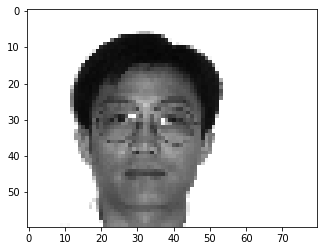

In [9]:
# Look at an image for fun
img = load_img(np.random.choice(files))
plt.imshow(img)
plt.show()

In [10]:
img.shape
# Although the images are grauscale but it was saved as color image
# So the value of image pixels are the same in different color channels
# We will not lose anything if we convert it to real grayscale image

(60, 80, 3)

In [11]:
np.all(img[:,:,0] == img[:,:,1]), np.all(img[:,:,0] == img[:,:,2])

(True, True)

In [12]:
print(img.max())

255


In [13]:
def to_grayscale(img):
  return img.mean(axis=-1) # mean through last axis

In [14]:
# Load all images as arrays
shape = (N , H, W)
images = np.zeros(shape)

for i, f in enumerate(files):
  img = to_grayscale(load_img(f)) / 255
  images[i] = img

In [15]:
# make the labels
# all the filenames are something like 'subject13.happy'
labels = np.zeros(N)
for i, f in enumerate(files): # yalefaces/subject13.happy
  filename = f.rsplit('/', maxsplit=1)[-1] # subject13.happy
  subject_num = filename.split('.', maxsplit=1)[0] # subject13

  idx = int(subject_num.replace('subject', '')) - 1 # subtract 1 because the filenames start from 1
  labels[i] = idx

video 5: Splitting the data into train and test

In [16]:
# How many of each subject do we have?
label_count = Counter(labels)
label_count # Except the first person there are 11 images for each subject

Counter({0.0: 12,
         1.0: 11,
         2.0: 11,
         3.0: 11,
         4.0: 11,
         5.0: 11,
         6.0: 11,
         7.0: 11,
         8.0: 11,
         9.0: 11,
         10.0: 11,
         11.0: 11,
         12.0: 11,
         13.0: 11,
         14.0: 11})

In [17]:
# Set of unique labels
unique_labels = set(label_count.keys())

In [18]:
# Get the number of subjects
n_subjects = len(label_count)
n_subjects

15

In [19]:
# Let's make it so 3 images for each subject are test data
# number of test points are then
n_test = n_subjects * 3
n_train = N - n_test

In [20]:
# Initialize arrays to hold train and test images
train_images = np.zeros([n_train] + list(img.shape))
train_labels = np.zeros(n_train)
test_images = np.zeros([n_test] + list(img.shape))
test_labels = np.zeros(n_test)

(train_images.shape, test_images.shape)
# Note we must split the images to train and test so that the images appears only in train or test dataset and don't mix them together

((121, 60, 80), (45, 60, 80))

In [21]:
# Fill up the array we have just initialized
count_so_far = {}
train_idx = 0
test_idx = 0
for img, label in zip(images, labels):
  # increment the count
  count_so_far[label] = count_so_far.get(label, 0) + 1

  if count_so_far[label] > 3:
    # We have already added 3 test images for this subject
    # so add  the rest to train
    train_images[train_idx] = img
    train_labels[train_idx] = label
    train_idx += 1
  else:
    # Add the first 3 images to test
    test_images[test_idx] = img
    test_labels[test_idx] = label
    test_idx += 1

Video 6: Converting the data into pairs

In [22]:
# Create label2idx mapping for easy access
train_label2idx = {}
test_label2idx = {}

for i, label in enumerate(train_labels):
  if label not in train_label2idx:
    train_label2idx[label] = [i]
  else:
    train_label2idx[label].append(i)

for i, label in enumerate(test_labels):
  if label not in test_label2idx:
    test_label2idx[label] = [i]
  else:
    test_label2idx[label].append(i)

In [23]:
train_label2idx

{0.0: [35, 36, 39, 42, 53, 54, 79, 84, 86],
 1.0: [0, 28, 33, 52, 67, 69, 83, 119],
 2.0: [29, 59, 62, 63, 77, 85, 89, 101],
 3.0: [11, 22, 23, 46, 68, 99, 107, 116],
 4.0: [1, 5, 21, 47, 93, 95, 105, 118],
 5.0: [38, 45, 65, 66, 96, 97, 100, 110],
 6.0: [14, 25, 37, 71, 109, 113, 114, 115],
 7.0: [10, 30, 41, 61, 81, 87, 111, 120],
 8.0: [6, 8, 32, 34, 56, 64, 88, 104],
 9.0: [13, 19, 48, 51, 55, 70, 75, 94],
 10.0: [3, 4, 7, 17, 20, 60, 73, 90],
 11.0: [27, 44, 49, 57, 74, 91, 92, 112],
 12.0: [2, 12, 15, 31, 43, 76, 78, 98],
 13.0: [18, 26, 40, 72, 82, 103, 106, 117],
 14.0: [9, 16, 24, 50, 58, 80, 102, 108]}

In [24]:
# Come up with all possible training sample indices
train_positives = [] # store the matches
train_negatives = [] # store the non-matches
test_positives = []
test_negatives = []

for label, indices in train_label2idx.items():
  # all indices that do NOT belong to this subject
  other_indices = set(range(n_train)) - set(indices)

  for i, idx1 in enumerate(indices):
    for idx2 in indices[i+1:]:
      train_positives.append((idx1, idx2))

    for idx2 in other_indices:
      train_negatives.append((idx1, idx2))

for label, indices in test_label2idx.items():
  # all indices that do NOT belong to this subject
  other_indices = set(range(n_test)) - set(indices)

  for i, idx1 in enumerate(indices):
    for idx2 in indices[i+1:]:
      test_positives.append((idx1, idx2))

    for idx2 in other_indices:
      test_negatives.append((idx1, idx2))

Video 7: Generating Generators

In [25]:
batch_size = 64
def train_generator():
  # For each batch we will send 1 pair of each subject
  # and the same number of non-matching pairs
  n_batches = int(np.ceil(len(train_positives) / batch_size))

  while True:
    np.random.shuffle(train_positives)
    n_samples = batch_size * 2
    shape = (n_samples, H, W)
    x_batch_1 = np.zeros(shape)
    x_batch_2 = np.zeros(shape)
    y_batch = np.zeros(n_samples)

    for i in range(n_batches):
      pos_batch_indices = train_positives[i * batch_size: (i+1) * batch_size]

      # Fill up x_batch and y_batch
      j = 0
      for idx1, idx2 in pos_batch_indices:
        x_batch_1[j] = train_images[idx1]
        x_batch_2[j] = train_images[idx2]
        y_batch[j] = 1 # match
        j += 1
      
      # Get negative samples
      neg_indices = np.random.choice(len(train_negatives), size=len(pos_batch_indices), replace=True)
      # Note: replace - boolean, optional Whether the sample is with or without replacement. Default is True, meaning that a value of a can be selected multiple times.
      for neg in neg_indices:
        idx1, idx2 = train_negatives[neg]
        x_batch_1[j] = train_images[idx1]
        x_batch_2[j] = train_images[idx2]
        y_batch[j] = 0 # non-match
        j += 1

      x1 = x_batch_1[:j]
      x2 = x_batch_2[:j]
      y = y_batch[:j]

      # Reshape
      x1 = x1.reshape(-1, 1, H, W)
      x2 = x2.reshape(-1, 1, H, W)

      # Convert to torch tensors
      x1 = torch.from_numpy(x1).float()
      x2 = torch.from_numpy(x2).float()
      y = torch.from_numpy(y).float()

      yield [x1, x2], y


In [26]:
# Same thing as the train generator except no shuffling and it uses the test set
def test_generator():
  n_batches = int(np.ceil(len(test_positives)/ batch_size))

  while True:
    n_samples = batch_size * 2
    shape = (n_samples, H, W)
    x_batch_1 = np.zeros(shape)
    x_batch_2 = np.zeros(shape)
    y_batch = np.zeros(n_samples)

    for i in range(n_batches):
      pos_batch_indices = test_positives[i * batch_size: (i+1) * batch_size]

      # Fill up x_batch and y_batch
      j = 0
      for idx1, idx2 in pos_batch_indices:
        x_batch_1[j] = test_images[idx1]
        x_batch_2[j] = test_images[idx2]
        y_batch[j] = 1 # match
        j += 1
      
      # Get negative samples
      neg_indices = np.random.choice(len(test_negatives), size=len(pos_batch_indices), replace=False)
      # Note: replace - boolean, optional Whether the sample is with or without replacement. Default is True, meaning that a value of a can be selected multiple times.
      for neg in neg_indices:
        idx1, idx2 = test_negatives[neg]
        x_batch_1[j] = test_images[idx1]
        x_batch_2[j] = test_images[idx2]
        y_batch[j] = 0 #non-match
        j += 1

      x1 = x_batch_1[:j]
      x2 = x_batch_2[:j]
      y = y_batch[:j]

      # Reshape
      x1 = x1.reshape(-1, 1, H, W)
      x2 = x2.reshape(-1, 1, H, W)

      # Convert to torch tensors
      x1 = torch.from_numpy(x1).float()
      x2 = torch.from_numpy(x2).float()
      y = torch.from_numpy(y).float()

      yield [x1, x2], y

Video 8: Creating the model and loss

In [27]:
# Build the model
class SiameseNN(nn.Module):
  def __init__(self, feature_dim):
    super().__init__()

    # Define CNN featurizer
    self.cnn = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(13*18*64, 128), # 60 -> 29 -> 13 | 80 -> 39 -> 18
        nn.ReLU(),
        nn.Linear(128, feature_dim), 

    )

  def forward(self, im1, im2):
    feat1 = self.cnn(im1)
    feat2 = self.cnn(im2)
    
    # Euclidean distance between feature 1 and feature 2
    return torch.norm(feat1 - feat2, dim=-1)


In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
model = SiameseNN(50)
model.to(device)

SiameseNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=14976, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=50, bias=True)
  )
)

In [30]:
# Loss function for siamese network
def contrastive_loss(y, t):
  nonmatch = F.relu(1 - y) # max(margin - y, 0)
  return torch.mean(t * y**2 + (1-t) * nonmatch**2)

In [31]:
# Loss and Optimizer
optimizer = torch.optim.Adam(model.parameters())

In [32]:
# A function to encapsulate the training loop
def batch_gd(
    model,
    criterion,
    optimizer,
    train_gen,
    test_gen,
    train_steps_per_epoch, # generator has an infinite while loop, so it is required to limit the loop
    test_steps_per_epoch,
    epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    steps = 0
    for (x1, x2), targets in train_gen:
      # Move data to GPU
      x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)
      
      # zero the parameters gradients
      optimizer.zero_grad()

      # Forward Pass
      outputs = model(x1, x2)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

      # Update steps
      steps += 1
      if steps >= train_steps_per_epoch:
        break
    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    test_loss = []
    steps = 0
    for (x1, x2), targets in test_gen:
      # Move data to GPU
      x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)

      # Forward Pass
      outputs = model(x1, x2)
      loss = criterion(outputs, targets)

      test_loss.append(loss.item())

      # Update steps
      steps += 1
      if steps >= test_steps_per_epoch:
        break
    
    test_loss = np.mean(test_loss) # a little misleading

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses


In [33]:
train_steps = int(np.ceil(len(train_positives)/batch_size))
test_steps = int(np.ceil(len(test_positives)/batch_size))

train_losses, test_losses = batch_gd(
    model,
    contrastive_loss,
    optimizer,
    train_generator(),
    test_generator(),
    train_steps, # generator has an infinite while loop, so it is required to limit the loop
    test_steps,
    epochs=20)

Epoch 1/20, Train Loss: 0.5454, Test Loss: 0.1853, Duration: 0:00:00.958063
Epoch 2/20, Train Loss: 0.1652, Test Loss: 0.1303, Duration: 0:00:00.650649
Epoch 3/20, Train Loss: 0.0999, Test Loss: 0.1138, Duration: 0:00:00.646388
Epoch 4/20, Train Loss: 0.0618, Test Loss: 0.0889, Duration: 0:00:00.646272
Epoch 5/20, Train Loss: 0.0417, Test Loss: 0.1099, Duration: 0:00:00.645013
Epoch 6/20, Train Loss: 0.0308, Test Loss: 0.0625, Duration: 0:00:00.645910
Epoch 7/20, Train Loss: 0.0232, Test Loss: 0.0817, Duration: 0:00:00.647261
Epoch 8/20, Train Loss: 0.0145, Test Loss: 0.0799, Duration: 0:00:00.645480
Epoch 9/20, Train Loss: 0.0115, Test Loss: 0.0676, Duration: 0:00:00.645292
Epoch 10/20, Train Loss: 0.0070, Test Loss: 0.0615, Duration: 0:00:00.653613
Epoch 11/20, Train Loss: 0.0056, Test Loss: 0.0668, Duration: 0:00:00.647685
Epoch 12/20, Train Loss: 0.0042, Test Loss: 0.0796, Duration: 0:00:00.648776
Epoch 13/20, Train Loss: 0.0029, Test Loss: 0.0760, Duration: 0:00:00.647039
Epoch 14

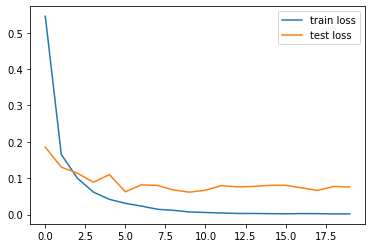

In [34]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

Video 9: Accuracy and imbalanced classes

In [39]:
# Convenience function to make prediction
def predict(x1, x2):
  x1 = torch.from_numpy(x1).float().to(device)
  x2 = torch.from_numpy(x2).float().to(device)
  with torch.no_grad():
    dist = model(x1, x2).cpu().numpy()
    return dist.flatten()

In [40]:
# Calculate accuracy before training
# Since the dataset is imbalanced, we will report tp, tn, fp, fn
def get_train_accuracy(threshold=0.85):
  positive_distances = []
  negative_distances = []
  tp = 0
  tn = 0
  fp = 0
  fn = 0

  batch_size = 64
  x_batch_1 = np.zeros((batch_size, 1, H, W))
  x_batch_2 = np.zeros((batch_size, 1, H, W))

  # Through Positives:
  n_batches = int(np.ceil(len(train_positives) / batch_size))

  for i in range(n_batches):
    print(f"pos batch: {i+1}/{n_batches}")
    pos_batch_indicies = train_positives[i * batch_size: (i+1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in pos_batch_indicies:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1
    
    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    positive_distances += distances.tolist()

    # Update tp, tn, fp, fn
    tp += (distances < threshold).sum()
    fn += (distances > threshold).sum()

  # Through Negatives:
  n_batches = int(np.ceil(len(train_negatives) / batch_size))
  for i in range(n_batches):
    print(f"neg batch: {i+1}/{n_batches}")
    neg_batch_indicies = train_negatives[i * batch_size: (i+1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in neg_batch_indicies:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1
    
    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    negative_distances += distances.tolist()

    # Update tp, tn, fp, fn
    fp += (distances < threshold).sum()
    tn += (distances > threshold).sum()

  tpr = tp / (tp + fn) # True Positive Rate
  tnr = tn / (tn + fp) # True Negative Rate
  print(f"Sensitivity (tpr): {tpr}, Specificity (tnr): {tnr}")

  plt.hist(negative_distances, bins=20, density=True, label='negative_distances')
  plt.hist(positive_distances, bins=20, density=True, label='positive_distances')
  plt.legend()
  plt.show()

In [41]:
# Calculate accuracy before training
# Since the dataset is imbalanced, we will report tp, tn, fp, fn
def get_test_accuracy(threshold=0.85):
  positive_distances = []
  negative_distances = []
  tp = 0
  tn = 0
  fp = 0
  fn = 0

  batch_size = 64
  x_batch_1 = np.zeros((batch_size, 1, H, W))
  x_batch_2 = np.zeros((batch_size, 1, H, W))

  # Through Positives:
  n_batches = int(np.ceil(len(test_positives) / batch_size))

  for i in range(n_batches):
    print(f"pos batch: {i+1}/{n_batches}")
    pos_batch_indicies = test_positives[i * batch_size: (i+1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in pos_batch_indicies:
      x_batch_1[j,0] = test_images[idx1]
      x_batch_2[j,0] = test_images[idx2]
      j += 1
    
    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    positive_distances += distances.tolist()

    # Update tp, tn, fp, fn
    tp += (distances < threshold).sum()
    fn += (distances > threshold).sum()

  # Through Negatives:
  n_batches = int(np.ceil(len(train_negatives) / batch_size))
  for i in range(n_batches):
    print(f"neg batch: {i+1}/{n_batches}")
    neg_batch_indicies = train_negatives[i * batch_size: (i+1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in neg_batch_indicies:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1
    
    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    negative_distances += distances.tolist()

    # Update tp, tn, fp, fn
    fp += (distances < threshold).sum()
    tn += (distances > threshold).sum()

  tpr = tp / (tp + fn) # True Positive Rate
  tnr = tn / (tn + fp) # True Negative Rate
  print(f"Sensitivity (tpr): {tpr}, Specificity (tnr): {tnr}")

  plt.hist(negative_distances, bins=20, density=True, label='negative_distances')
  plt.hist(positive_distances, bins=20, density=True, label='positive_distances')
  plt.legend()
  plt.show()

pos batch: 1/7
pos batch: 2/7
pos batch: 3/7
pos batch: 4/7
pos batch: 5/7
pos batch: 6/7
pos batch: 7/7
neg batch: 1/214
neg batch: 2/214
neg batch: 3/214
neg batch: 4/214
neg batch: 5/214
neg batch: 6/214
neg batch: 7/214
neg batch: 8/214
neg batch: 9/214
neg batch: 10/214
neg batch: 11/214
neg batch: 12/214
neg batch: 13/214
neg batch: 14/214
neg batch: 15/214
neg batch: 16/214
neg batch: 17/214
neg batch: 18/214
neg batch: 19/214
neg batch: 20/214
neg batch: 21/214
neg batch: 22/214
neg batch: 23/214
neg batch: 24/214
neg batch: 25/214
neg batch: 26/214
neg batch: 27/214
neg batch: 28/214
neg batch: 29/214
neg batch: 30/214
neg batch: 31/214
neg batch: 32/214
neg batch: 33/214
neg batch: 34/214
neg batch: 35/214
neg batch: 36/214
neg batch: 37/214
neg batch: 38/214
neg batch: 39/214
neg batch: 40/214
neg batch: 41/214
neg batch: 42/214
neg batch: 43/214
neg batch: 44/214
neg batch: 45/214
neg batch: 46/214
neg batch: 47/214
neg batch: 48/214
neg batch: 49/214
neg batch: 50/214
neg 

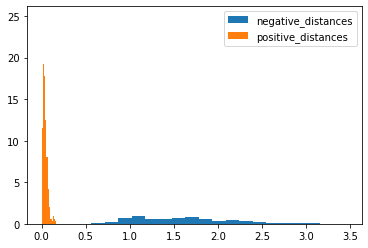

In [42]:
# Get Train Accuracy
get_train_accuracy(0.65)

pos batch: 1/1
neg batch: 1/214
neg batch: 2/214
neg batch: 3/214
neg batch: 4/214
neg batch: 5/214
neg batch: 6/214
neg batch: 7/214
neg batch: 8/214
neg batch: 9/214
neg batch: 10/214
neg batch: 11/214
neg batch: 12/214
neg batch: 13/214
neg batch: 14/214
neg batch: 15/214
neg batch: 16/214
neg batch: 17/214
neg batch: 18/214
neg batch: 19/214
neg batch: 20/214
neg batch: 21/214
neg batch: 22/214
neg batch: 23/214
neg batch: 24/214
neg batch: 25/214
neg batch: 26/214
neg batch: 27/214
neg batch: 28/214
neg batch: 29/214
neg batch: 30/214
neg batch: 31/214
neg batch: 32/214
neg batch: 33/214
neg batch: 34/214
neg batch: 35/214
neg batch: 36/214
neg batch: 37/214
neg batch: 38/214
neg batch: 39/214
neg batch: 40/214
neg batch: 41/214
neg batch: 42/214
neg batch: 43/214
neg batch: 44/214
neg batch: 45/214
neg batch: 46/214
neg batch: 47/214
neg batch: 48/214
neg batch: 49/214
neg batch: 50/214
neg batch: 51/214
neg batch: 52/214
neg batch: 53/214
neg batch: 54/214
neg batch: 55/214
neg 

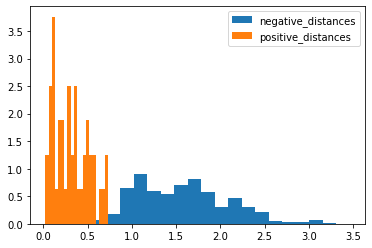

In [43]:
# Get Test Accuracy
get_test_accuracy()